In [18]:
# !pip install mne
# !pip install torch-scatter
# !pip install torch-sparse
# !pip install torch-geometric

import time_series_explainer.ts_explainer as ts_explainer
import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from scipy.spatial import Delaunay
import networkx as nx
import scipy.sparse as sp
import time
from sklearn.neighbors import NearestNeighbors

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import Scaler

from torch_geometric.data import Data, InMemoryDataset

## Грузим данные

In [3]:
DATA_PATH = './eeg_model_sidorov/'

train_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_A_Train.mat')
train_B_raw = scipy.io.loadmat(DATA_PATH + 'Subject_B_Train.mat')
test_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_A_Test.mat')
test_B_raw = scipy.io.loadmat(DATA_PATH + 'Subject_B_Test.mat')

eloc = mne.channels.read_custom_montage(DATA_PATH + 'eloc64.loc')

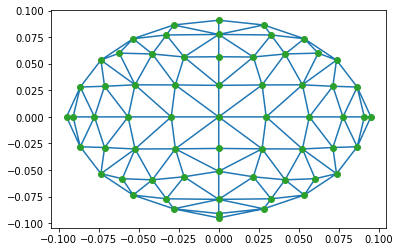

In [4]:
positions = eloc.get_positions()['ch_pos']
points = np.stack(list(positions.values()))
ch_names = np.stack(list(positions.keys()))

tri = Delaunay(points)

plt.triplot(points[:,0], points[:,1], triangles=tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [5]:
G = nx.Graph()
for ind, (pos, label) in enumerate(zip(points, ch_names)):
    G.add_node(ind, pos=pos, label=label)

for path in tri.simplices[:, 1:]:
    nx.add_cycle(G, path)

for node in [23, 26, 34, 35, 28, 36]:
    G.add_edge(27, node)

G.remove_edge(63, 42)
G.remove_edge(63, 43)
G.remove_edge(42, 43)

A = nx.adjacency_matrix(G)
D1 = np.diag(np.sqrt(1 / A.toarray().sum(axis=1)))

A_tild = A + sp.eye(A.shape[0])
A_tild = torch.FloatTensor(D1 @ A_tild.toarray() @ D1)

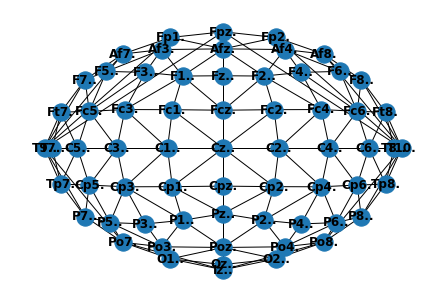

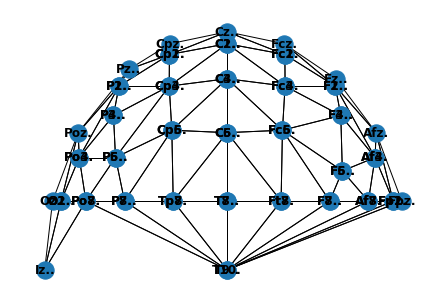

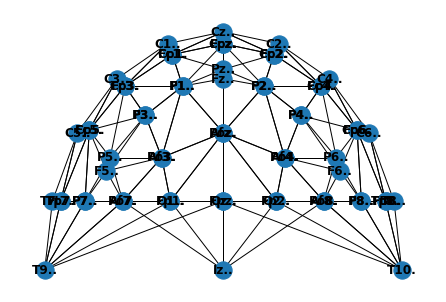

In [6]:
labels = dict()
pos = []

for i, node in enumerate(G.nodes):
    labels[i] = G.nodes[i]['label']
    pos.append(G.nodes[i]['pos'])

pos = np.array(pos)

nx.draw(G, labels=labels, font_weight='bold', pos=pos[:,:2])
plt.show()
nx.draw(G, labels=labels, font_weight='bold', pos=pos[:,1:])
plt.show()
nx.draw(G, labels=labels, font_weight='bold', pos=pos[:,[0, 2]])
plt.show()

In [7]:
row_dict = []
row_dict += list(zip(['A', 'B', 'C', 'D', 'E', 'F'], [7] * 6))
row_dict += list(zip(['G', 'H', 'I', 'J', 'K', 'L'], [8] * 6))
row_dict += list(zip(['M', 'N', 'O', 'P', 'Q', 'R'], [9] * 6))
row_dict += list(zip(['S', 'T', 'U', 'V', 'W', 'X'], [10] * 6))
row_dict += list(zip(['Y', 'Z', '1', '2', '3', '4'], [11] * 6))
row_dict += list(zip(['5', '6', '7', '8', '9', '_'], [12] * 6))

row_dict = dict(row_dict)

In [8]:
col_dict = []
col_dict += list(zip(['A', 'G', 'M', 'S', 'Y', '5'], [1] * 6))
col_dict += list(zip(['B', 'H', 'N', 'T', 'Z', '6'], [2] * 6))
col_dict += list(zip(['C', 'I', 'O', 'U', '1', '7'], [3] * 6))
col_dict += list(zip(['D', 'J', 'P', 'V', '2', '8'], [4] * 6))
col_dict += list(zip(['E', 'K', 'Q', 'W', '3', '9'], [5] * 6))
col_dict += list(zip(['F', 'L', 'R', 'X', '4', '_'], [6] * 6))

col_dict = dict(col_dict)

In [9]:
info = mne.create_info(ch_names=eloc.ch_names, 
                           ch_types=['eeg'] * 64, 
                           sfreq=120)

## Вспомогательные функции

In [10]:
def filter(X):
    train_array = mne.io.RawArray(X.T, info, verbose=False)
    train_array.set_montage(eloc)
    return train_array.filter(1,20, method='iir', verbose=False).get_data()

In [11]:
def p300_set(raw_data, target_chars=None):
    X = []
    y = []

    for epoch_num in range(len(raw_data['Flashing'])):
        epoch_flash = raw_data['Flashing'][epoch_num]
        idx = np.where(epoch_flash[:-1] != epoch_flash[1:])[0][1::2] + 1
        idx_t = np.where(epoch_flash[:-1] != epoch_flash[1:])[0] + 1
        
        res = raw_data['Signal'][epoch_num].T#filter(raw_data['Signal'][epoch_num])
        res = np.split(res.T, idx, axis=0)
        if target_chars:
            rows = (raw_data['StimulusCode'][epoch_num][np.insert(idx_t, 0, 0)] == row_dict[target_chars[epoch_num]]).astype(int)
            cols = (raw_data['StimulusCode'][epoch_num][np.insert(idx_t, 0, 0)] == col_dict[target_chars[epoch_num]]).astype(int)

            target = rows + cols
        else:
            target = raw_data['StimulusType'][epoch_num][np.insert(idx_t, 0, 0)]

        target = target[::2]

        res[-1] = res[-1][:42]

        #res, target = upsample(np.concatenate([res]), np.stack(target))

        X.append(res)
        y.append(target)

    X = np.transpose(np.concatenate(X), (0, 2, 1))
    y = np.concatenate(y)

    return X, y

## Standart Dataset

In [12]:
train_A_chars = list(train_A_raw['TargetChar'][0])
train_B_chars = list(train_B_raw['TargetChar'][0])
test_A_chars = list('WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU')
test_B_chars = list('MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR')

In [13]:
X_train_A, y_train_A = p300_set(train_A_raw) # , target_chars=train_A_chars
X_train_B, y_train_B = p300_set(train_B_raw) # , target_chars=train_B_chars
X_test_A, y_test_A = p300_set(test_A_raw, target_chars=test_A_chars)
X_test_B, y_test_B = p300_set(test_B_raw, target_chars=test_B_chars)

In [14]:
scaler_A = Scaler(info)
scaler_B = Scaler(info)

X_train_A = scaler_A.fit_transform(X_train_A)
X_test_A = scaler_A.transform(X_test_A)

X_train_B = scaler_B.fit_transform(X_train_B)
X_test_B = scaler_B.transform(X_test_B)

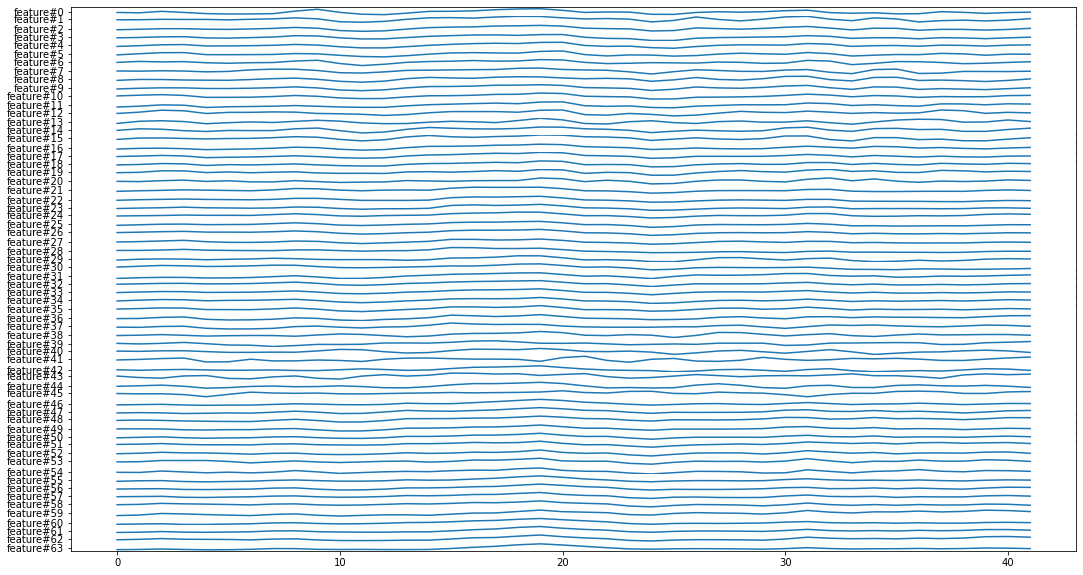

In [26]:
fig, _ = ts_explainer.plot_eeg(X_train_A[0], figsize=(18, 10))

In [35]:
X_train_A.shape

torch.Size([15300, 64, 42])

In [36]:
def to_tensor(X_train, y_train):
    X_train = torch.tensor(X_train)
    y_train = torch.tensor(y_train)

    return X_train.float(), y_train.float()

In [37]:
X_train_A, y_train_A = to_tensor(X_train_A, y_train_A)
X_train_B, y_train_B = to_tensor(X_train_B, y_train_B)

X_test_A, y_test_A = to_tensor(X_test_A, y_test_A)
X_test_B, y_test_B = to_tensor(X_test_B, y_test_B)

/var/folders/wg/94j9k5cn175f96w8xqmncds9jx4k56/T/ipykernel_61940/811647691.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train)
/var/folders/wg/94j9k5cn175f96w8xqmncds9jx4k56/T/ipykernel_61940/811647691.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train)


In [38]:
class EEGDataset(Dataset):
    """
    TensorDataset with support of transforms.
    """
    def __init__(self, tensors, with_target=True, transform=None, num_classes=2):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform
        self.with_target = with_target
        self.num_classes = num_classes

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        if self.with_target:
            y = self.tensors[1][index]
            #y = (torch.arange(0, self.num_classes) == y).float()
            return x, y.unsqueeze(0).float()
        else:
            return x

    def __len__(self):
        return self.tensors[0].size(0)

In [39]:
X_a = torch.cat([X_train_A, X_test_A])
y_a = torch.cat([y_train_A, y_test_A])

In [40]:
train_A_dataset = EEGDataset(tensors=(X_a[:25000], y_a[:25000]), with_target=True, transform=None)
test_A_dataset = EEGDataset(tensors=(X_a[25000:], y_a[25000:]), with_target=True, transform=None)

batch_size = 210

train_A_CNN = DataLoader(train_A_dataset, batch_size=batch_size)
test_A_CNN = DataLoader(test_A_dataset, batch_size=batch_size)

data_loaders_CNN = {'train':train_A_CNN, 'val':test_A_CNN}

## Graph Dataset

In [2]:
import os

In [4]:
os.getcwd()

'/Users/tytskiy/Education/Bachelor-s-Thesis'

In [44]:
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(MyOwnDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return [DATA_PATH + 'model_lkj']

    def download(self):
        pass

    def process(self):
        # Read data into huge `Data` list.
        data_list = []

        # process by session_id
        DATA_PATH = './eeg_model_sidorov/'
        train_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_A_Train.mat')
        test_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_A_Test.mat')
        eloc = mne.channels.read_custom_montage(DATA_PATH + 'eloc64.loc')

        positions = eloc.get_positions()['ch_pos']
        points = np.stack(list(positions.values()))
        ch_names = np.stack(list(positions.keys()))

        tri = Delaunay(points)

        G = nx.Graph()
        for ind, (pos, label) in enumerate(zip(points, ch_names)):
            G.add_node(ind, pos=pos, label=label)
        for path in tri.simplices[:, 1:]:
            nx.add_cycle(G, path)
        for node in [23, 26, 34, 35, 28, 36]:
            G.add_edge(27, node)
        G.remove_edge(63, 42)
        G.remove_edge(63, 43)
        G.remove_edge(42, 43)

        B = nx.adjacency_matrix(G).toarray()
        t = np.where(B == 1)
        edge_index = torch.tensor(np.stack([t[0].flatten(), t[1].flatten()]), dtype=torch.long)

        X_train_A, y_train_A = p300_set(train_A_raw)
        test_A_chars = list('WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU')
        X_test_A, y_test_A = p300_set(test_A_raw, target_chars=test_A_chars)
        scaler_A = Scaler(info)

        X_train_A, y_train_A = to_tensor(X_train_A, y_train_A)
        X_test_A, y_test_A = to_tensor(X_test_A, y_test_A)

        y_total = torch.cat([y_train_A, y_test_A])
        X_total = torch.cat([X_train_A, X_test_A])

        for i in tqdm(range(X_total.shape[0])):
            x = X_total[i]
            y = y_total[i].unsqueeze(0)

            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [45]:
A_data = MyOwnDataset("MYdata")

Processing...
100%|██████████████████████████████████| 33300/33300 [00:00<00:00, 46920.69it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'MYdata/processed/./eeg_model_sidorov/model_lkj'

In [ ]:
from torch_geometric.loader import DataLoader as GraphLoader

batch_size = 210

train_A_GNN = GraphLoader(A_data[:25000], batch_size=batch_size)
test_A_GNN = GraphLoader(A_data[25000:], batch_size=batch_size)

data_loaders_GNN = {'train':train_A_GNN, 'val':test_A_GNN}

## Модели

In [ ]:
class Linear_model(nn.Module):
    def __init__(self, input_feat_dim, n_channels=64, num_classes=2):
        super(Linear_model, self).__init__()

        self.classifier = nn.Linear(input_feat_dim * n_channels, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x#.flatten()

In [ ]:
class Small_CNN(nn.Module):
    def __init__(self, input_feat_dim, n_channels=64, num_classes=2):
        super(Small_CNN, self).__init__()

        self.gc1 = nn.Conv1d(n_channels, n_channels * 2, kernel_size=3, padding=1)
        self.gc2 = nn.Conv1d(n_channels * 2, n_channels * 4, kernel_size=3, padding=1)

        self.pool1 = nn.MaxPool1d(2, stride=2)

        self.act1 = nn.ReLU(True)
        self.act2 = nn.ReLU(True)

        self.classifier = nn.Linear(input_feat_dim // 2 * n_channels * 4, num_classes)

    def forward(self, x):
        x = self.act1(self.gc1(x))

        x = self.act2(self.gc2(x))
        x = self.pool1(x)

        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x#.flatten()

In [ ]:
from torch_geometric.nn import TopKPooling, GINConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

class GCNModel(nn.Module):
    def __init__(self, input_feat_dim, n_channels=64, num_classes=2):
        super(GCNModel, self).__init__()

        self.gc1 = GINConv(nn.Linear(input_feat_dim, input_feat_dim * 2))
        self.gc2 = GINConv(nn.Linear(input_feat_dim * 2, input_feat_dim * 4))

        self.pool1 = TopKPooling(input_feat_dim * 4, 0.5)

        self.act1 = nn.ReLU(True)
        self.act2 = nn.ReLU(True)
    
        self.classifier = nn.Linear(input_feat_dim * 4, num_classes, bias=True)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.act1(self.gc1(x, edge_index))
        
        x = self.act2(self.gc2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)

        x = gmp(x, batch)
        x = self.classifier(x)
        
        return x.flatten()

## Результаты

In [ ]:
def train_model(model, dataloaders, criterion, num_epochs=10, device='cpu'):
    since = time.time()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    model = model.to(device)

    val_acc_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs) #torch.sigmoid(
                
                loss = criterion(outputs, labels)
                #_, preds = torch.max(outputs, 1)
                preds = torch.round(torch.sigmoid(outputs))
                #_, true_y = torch.max(labels.data, 1)
                true_y = torch.round(labels.data)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == true_y)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                val_acc_history.append(epoch_acc.cpu().data)
                val_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return np.array(val_loss_history), np.array(val_acc_history), time_elapsed

In [ ]:
def train_GCN_model(model, dataloaders, criterion, num_epochs=10, device='cpu'):
    since = time.time()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    model = model.to(device)

    val_acc_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                data = data.to(device)
                labels = data.y.to(device)

                optimizer.zero_grad()

                outputs = model(data) #torch.sigmoid(
                
                loss = criterion(outputs, labels)
                #_, preds = torch.max(outputs, 1)
                preds = torch.round(torch.sigmoid(outputs))
                #_, true_y = torch.max(labels.data, 1)
                true_y = torch.round(labels.data)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * data.x.size(0)
                running_corrects += torch.sum(preds == true_y)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                val_acc_history.append(epoch_acc.cpu().data)
                val_loss_history.append(epoch_loss.cpu().data)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return np.array(val_loss_history), np.array(val_acc_history), time_elapsed

## Теперь точно результаты

In [ ]:
# Graph model
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3)) 

num_epochs = 100
lr = 1e-3
weight_decay = 1e-1
step_size = 5
gamma = 1

my_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

A_tild = A_tild.to(my_device)
model = GCNModel(42, n_channels=64, num_classes=1)
#model = Net()

loss, acc, total_time = train_GCN_model(model, data_loaders_GNN, criterion, num_epochs=num_epochs, device=my_device)

cuda:0
Epoch 0/99
----------
train Loss: 542.3530 Acc: 0.5832
val Loss: 124.9389 Acc: 0.6620

Epoch 1/99
----------
train Loss: 148.7571 Acc: 0.6024
val Loss: 98.9244 Acc: 0.6325

Epoch 2/99
----------
train Loss: 108.4619 Acc: 0.6130
val Loss: 86.9042 Acc: 0.6341

Epoch 3/99
----------
train Loss: 85.3428 Acc: 0.6276
val Loss: 78.4450 Acc: 0.6331

Epoch 4/99
----------
train Loss: 86.7897 Acc: 0.6400
val Loss: 73.3219 Acc: 0.6611

Epoch 5/99
----------
train Loss: 90.1934 Acc: 0.6452
val Loss: 69.6504 Acc: 0.6812

Epoch 6/99
----------
train Loss: 79.3526 Acc: 0.6620
val Loss: 65.5310 Acc: 0.6873

Epoch 7/99
----------
train Loss: 69.1061 Acc: 0.6904
val Loss: 63.6100 Acc: 0.7047

Epoch 8/99
----------
train Loss: 63.5384 Acc: 0.7062
val Loss: 62.5161 Acc: 0.7248

Epoch 9/99
----------
train Loss: 60.3094 Acc: 0.7269
val Loss: 61.5780 Acc: 0.7304

Epoch 10/99
----------
train Loss: 58.0248 Acc: 0.7432
val Loss: 60.8065 Acc: 0.7359

Epoch 11/99
----------
train Loss: 57.0151 Acc: 0.753

In [ ]:
np.max(list(map(lambda x: x.cpu().data, acc)))

0.8330120481927711

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

18229

In [ ]:
# standart cnn
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3)) # pos_weight=torch.tensor([1, 10])

num_epochs = 100
lr = 1e-3
weight_decay = 1e-1
step_size = 5
gamma = 1

my_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

model = Small_CNN(42, n_channels=64, num_classes=1)

loss, acc, total_time = train_model(model, data_loaders_CNN, criterion, num_epochs=num_epochs, device=my_device)

cuda:0
Epoch 0/99
----------
train Loss: 171572.4903 Acc: 0.5742
val Loss: 4866.4074 Acc: 0.5810

Epoch 1/99
----------
train Loss: 2342.4244 Acc: 0.6447
val Loss: 1162.8152 Acc: 0.6701

Epoch 2/99
----------
train Loss: 597.1874 Acc: 0.7212
val Loss: 530.6087 Acc: 0.7171

Epoch 3/99
----------
train Loss: 254.8211 Acc: 0.7582
val Loss: 365.7689 Acc: 0.7301

Epoch 4/99
----------
train Loss: 131.6992 Acc: 0.7766
val Loss: 276.5268 Acc: 0.7405

Epoch 5/99
----------
train Loss: 69.9131 Acc: 0.7880
val Loss: 223.4901 Acc: 0.7725

Epoch 6/99
----------
train Loss: 39.8024 Acc: 0.8001
val Loss: 199.6783 Acc: 0.7780

Epoch 7/99
----------
train Loss: 25.9994 Acc: 0.8045
val Loss: 184.5451 Acc: 0.7759

Epoch 8/99
----------
train Loss: 17.8352 Acc: 0.8114
val Loss: 176.1705 Acc: 0.7800

Epoch 9/99
----------
train Loss: 12.8028 Acc: 0.8150
val Loss: 170.7105 Acc: 0.7878

Epoch 10/99
----------
train Loss: 11.0564 Acc: 0.8167
val Loss: 167.1688 Acc: 0.7878

Epoch 11/99
----------
train Loss: 

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

128641

In [ ]:
acc.max()

0.8289156626506023

In [ ]:
# linear baseline
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))

num_epochs = 100
lr = 1e-3
weight_decay = 1e-1
step_size = 5
gamma = 0.1

model = Linear_model(42, n_channels=64, num_classes=1) #161

my_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

loss, acc, total_time = train_model(model, data_loaders_CNN, criterion, num_epochs=num_epochs, device=my_device)

cuda:0
Epoch 0/99
----------
train Loss: 3453031.7015 Acc: 0.5789
val Loss: 1370679.7299 Acc: 0.5933

Epoch 1/99
----------
train Loss: 1988516.2044 Acc: 0.5865
val Loss: 1124577.9412 Acc: 0.6365

Epoch 2/99
----------
train Loss: 2238997.6164 Acc: 0.5879
val Loss: 1143971.3012 Acc: 0.6102

Epoch 3/99
----------
train Loss: 1814650.4865 Acc: 0.5902
val Loss: 1487679.5678 Acc: 0.5499

Epoch 4/99
----------
train Loss: 2140274.5392 Acc: 0.5922
val Loss: 1385204.8825 Acc: 0.6187

Epoch 5/99
----------
train Loss: 1814671.3739 Acc: 0.5902
val Loss: 966323.6555 Acc: 0.6117

Epoch 6/99
----------
train Loss: 2072551.5956 Acc: 0.5976
val Loss: 780230.1989 Acc: 0.5878

Epoch 7/99
----------
train Loss: 2096730.5184 Acc: 0.5928
val Loss: 1288272.1428 Acc: 0.5481

Epoch 8/99
----------
train Loss: 3220805.7944 Acc: 0.5995
val Loss: 867840.0467 Acc: 0.6299

Epoch 9/99
----------
train Loss: 2139530.0666 Acc: 0.6020
val Loss: 1513255.5125 Acc: 0.5486

Epoch 10/99
----------
train Loss: 2985103.680

In [ ]:
acc.max()

0.689156626506024